In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
trainDf = pd.read_csv('CheXpert-v1.0-small/train.csv')

# Preliminary Analysis

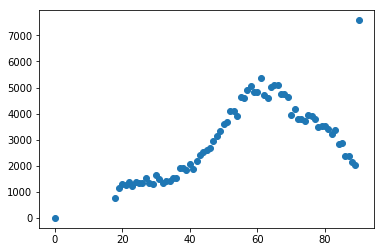

In [21]:
# Shows age distribution of the data set. There are 3 0-olds and 7579 90 year olds. 
# Implies that over nineties were grouped together
ages = trainDf['Age'].value_counts()
plt.scatter(ages.keys(),ages.values)

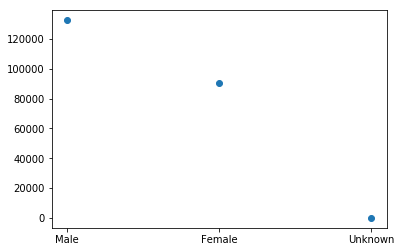

In [22]:
gender = trainDf['Sex'].value_counts()
plt.scatter(gender.keys(),gender.values)

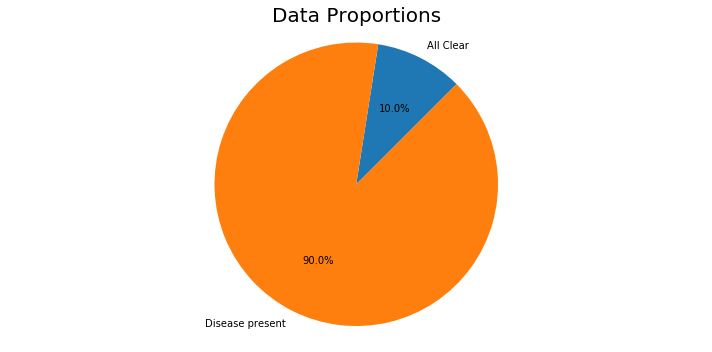

In [51]:
# How many people have no disease?
no_finding = trainDf['No Finding'].value_counts()
no_finding['0'] = len(trainDf) - no_finding.values[0]

# Plot pie chart to show how much of the data is labelled with each character
values = no_finding.values
labels = [ 'All Clear','Disease present']

# Plot
plt.figure(figsize=(10, 5))
plt.title('Data Proportions', size=20)
plt.pie(values, labels=labels, # explode=explode,
        autopct='%1.1f%%', shadow=False, startangle=45)
 
plt.axis('equal')
plt.tight_layout()
plt.show()